# Lesson 8: Convolutional Neural Networks

In the final lecture of Part 1 of the Fast.AI course, we covered convolutional neural networks. I actually already built a convolutional neural network in one of the previous mini-projects, so I'll be upgrading that by implementing max pooling and dropout layers to see if that helps out our performance on the MNIST dataset.


When we last left off, we had implemented a multi-layer CNN with the following classes:

In [2]:

import os
from pathlib import Path

import numpy as np 
import pandas as pd 
import torch

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [73]:
class ConvolutionalLayer:
    def __init__(self, in_channels, out_channels, wr=3, wc=3, activation = torch.relu):
        self.filters = torch.nn.Parameter(-2 * torch.rand(out_channels, in_channels, wr, wc) + 1, requires_grad=True)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.window = (wr, wc)
        self.activation = activation
        
        
    def forward(self, x):
        steps_r, steps_c = x.shape[2] - self.window[0] + 1, x.shape[3] - self.window[1] + 1
        inp_unf = torch.nn.functional.unfold(x, self.window)
        out_unf = inp_unf.transpose(1,2).matmul(self.filters.view(self.filters.size(0), -1).t()).transpose(1, 2)
        out = torch.nn.functional.fold(out_unf, (steps_r, steps_c), (1,1))
        return self.activation(out)
    
    def adjust_weights(self, lr):
        self.filters.sub_(self.filters.grad * lr)
        self.filters.grad.zero_()

class DenseLayer:
    def __init__(self, in_channels, out_channels, activation=torch.relu):
        self.weights = torch.nn.Parameter(-2 * torch.rand(in_channels, out_channels) + 1, requires_grad=True)
        self.bias = torch.nn.Parameter(torch.rand(out_channels), requires_grad=True)
        self.activation = activation
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        return self.activation(x@self.weights + self.bias)
    
    def adjust_weights(self, lr):
        self.weights.sub_(self.weights.grad * lr)
        self.weights.grad.zero_()
        self.bias.sub_(self.bias.grad * lr)
        self.bias.grad.zero_()

class SeqNeuralNetFromScratch:
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def adjust_weights(self, lr):
        with torch.no_grad():
            for layer in self.layers:
                layer.adjust_weights(lr)

In this mini-project, I'll use AveragePooling, MaxPooling, and Dropout layers, and evaluate our model's performance to see if we can improve upon our previous results. All these extra layers are designed to help the model deal with overfitting, so perhaps we can get away with expanding the parameter space a bit as well.

Our previous network looked like this:

In [4]:
NUM_EPOCHS = 12
LEARNING_RATE = 0.105
BATCH_SIZE = 20
nn = SeqNeuralNetFromScratch([
    ConvolutionalLayer(1, 9, activation=torch.relu),
    # AvgPoolingLayer(),
    # DropoutLayer(),
    ConvolutionalLayer(9, 5, activation=torch.relu),
    # AvgPoolingLayer(),
    # DropoutLayer(),
    ConvolutionalLayer(5, 3, activation=torch.relu),
    # MaxPoolingLayer(),
    DenseLayer(1452, 10, activation=lambda x: x)
])

We could try to modify it such that we insert the commented-out layers.

First let's focus on dropout layers:

In [77]:
class DropoutLayer:
    def __init__(self, input_dimensions, dropout_threshold=0.2):
        noise_field = (torch.randn(input_dimensions) + 1) / 2
        self.mask = torch.gt(noise_field, dropout_threshold)
        
    def forward(self, x):
        return x * self.mask
    
    def adjust_weights(self, *args):
        pass

In [40]:
dl = DropoutLayer((2,2,2))
dl.forward(torch.randn(4,2,2,2))

tensor([[[[-0.3327,  0.0172],
          [-1.7616,  0.5177]],

         [[-1.5060, -1.9980],
          [ 0.0000,  1.4404]]],


        [[[ 0.4010, -0.2816],
          [-2.3383, -0.3448]],

         [[-0.3433, -0.7621],
          [ 0.0000,  0.6426]]],


        [[[-1.0288,  1.6408],
          [ 1.3915, -1.1526]],

         [[ 0.6998, -0.1771],
          [ 0.0000,  0.3938]]],


        [[[ 0.3510,  1.1370],
          [ 0.5661, -0.1546]],

         [[-0.8991, -0.2126],
          [ 0.0000, -1.0766]]]])

Next, we need AveragePooling and MaxPooling. While logically these are pretty straightforward to think about, implementing them in a vectorized way that maintains torch's graph correctly isn't so straightforward. There isn't really a trick I could think up to implement this with raw pytorch, so we will use the existing implementations that pytorch provides. I'll still put them in wrappers so they work with our network mini-framework.

In [72]:
class MaxPoolingLayer:
    def __init__(self, window_size=(3,3)):
        self.window_size = window_size
    def forward(self, x):
        return torch.nn.functional.max_pool2d(x, self.window_size)
    def adjust_weights(self, *args):
        pass
    
class AvgPoolingLayer:
    def __init__(self, window_size=(3,3)):
        self.window_size = window_size
        
    def forward(self, x):
        return torch.nn.functional.avg_pool2d(x, self.window_size)
    
    def adjust_weights(self, *args):
        pass
    
ap = AvgPoolingLayer()
mp = MaxPoolingLayer()

In [44]:
ap.forward(torch.randn(4,4,4,4))

tensor([[[[-0.1769]],

         [[-0.3316]],

         [[ 0.0404]],

         [[-0.2204]]],


        [[[-0.7207]],

         [[-0.5295]],

         [[ 0.2044]],

         [[ 0.2160]]],


        [[[ 0.1497]],

         [[ 0.0098]],

         [[ 0.5093]],

         [[-0.0806]]],


        [[[ 0.0219]],

         [[-0.5911]],

         [[ 0.5175]],

         [[ 0.0046]]]])

In [48]:
mp.forward(torch.randn(4,4,4,4))

tensor([[[[1.1859]],

         [[2.6633]],

         [[1.1307]],

         [[1.4147]]],


        [[[1.4233]],

         [[1.8901]],

         [[0.7890]],

         [[2.1011]]],


        [[[1.9414]],

         [[0.9723]],

         [[1.1345]],

         [[1.2155]]],


        [[[1.8067]],

         [[1.2279]],

         [[0.8347]],

         [[0.5997]]]])

In [84]:
NUM_EPOCHS = 12
LEARNING_RATE = 0.105
BATCH_SIZE = 20
nn = SeqNeuralNetFromScratch([
    ConvolutionalLayer(1, 15, activation=torch.relu),
    DropoutLayer((15,26,26)),
    ConvolutionalLayer(15, 9, activation=torch.relu),
    AvgPoolingLayer((2,2)),
    DropoutLayer((9,12,12)),
    ConvolutionalLayer(9, 5, activation=torch.relu),
    MaxPoolingLayer(),
    DenseLayer(45, 10, activation=lambda x: x)
])


In [75]:

nn.forward(torch.randn(5,1,28,28))

tensor([[ 45.2858,  -8.3504,  46.0129, -53.1510,  40.0230, -15.9569,  28.1411,
          -9.7503, -87.9375,  37.4521],
        [ 34.2253, -65.4257,  22.2469, -81.2536,  71.6366, -30.0335,  32.8414,
         -36.8910, -38.5060,  15.1047],
        [ 16.8213,   9.9270,  36.3600, -56.1003,  37.5867,  25.9311,  -1.2828,
         -65.9415, -33.2625,  28.0166],
        [ 29.6781,   6.8209,  24.9277, -82.8266,  27.9492, -28.3204,  22.2420,
         -64.1103,   1.8312,  24.1831],
        [-22.6391,  12.3686,  57.5527, -33.7802,  21.0425,   6.7277,  -7.0864,
          -1.4596, -68.8765,  10.9166]], grad_fn=<AddBackward0>)

In [85]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
inputs = torch.unsqueeze(torch.reshape(torch.tensor(df[df.columns[1:]].values), (42000, 28, 28)), 1)
labels = torch.tensor(df['label'].values)
inputs = inputs / 255

train_inputs, valid_inputs = torch.split(inputs, [37000, 5000])
train_labels, valid_labels = torch.split(labels, [37000, 5000])


cross_entropy_loss = torch.nn.CrossEntropyLoss()

input_batches = torch.split(train_inputs, BATCH_SIZE)
label_batches = torch.split(train_labels, BATCH_SIZE)

v_input_batches = torch.split(valid_inputs, BATCH_SIZE)
v_label_batches = torch.split(valid_labels, BATCH_SIZE)

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    running_accuracy = 0.0
    for batch_num, (i, l) in enumerate(zip(input_batches, label_batches)):
        i.requires_grad_ = True
        out = nn.forward(i)
        loss = cross_entropy_loss(out, l)
        loss.backward()
        nn.adjust_weights(LEARNING_RATE)
        running_loss += loss.item()
        
        preds = torch.argmax(out, 1)
        running_accuracy += (preds == l).float().sum().item() / BATCH_SIZE
        
    training_losses.append(running_loss / len(input_batches))
    training_accuracies.append(running_accuracy / len(input_batches))
    
    running_loss = 0.0
    running_accuracy = 0.0
    for batch_num, (i, l) in enumerate(zip(v_input_batches, v_label_batches)):
        with torch.no_grad():
            out = nn.forward(i)
            loss = cross_entropy_loss(out, l)
            running_loss += loss.item()
            preds = torch.argmax(out, 1)
            running_accuracy += (preds == l).float().sum().item() / BATCH_SIZE
            
    validation_losses.append(running_loss / len(v_input_batches))
    validation_accuracies.append(running_accuracy / len(v_input_batches))

Text(0.5, 1.0, 'Accuracy')

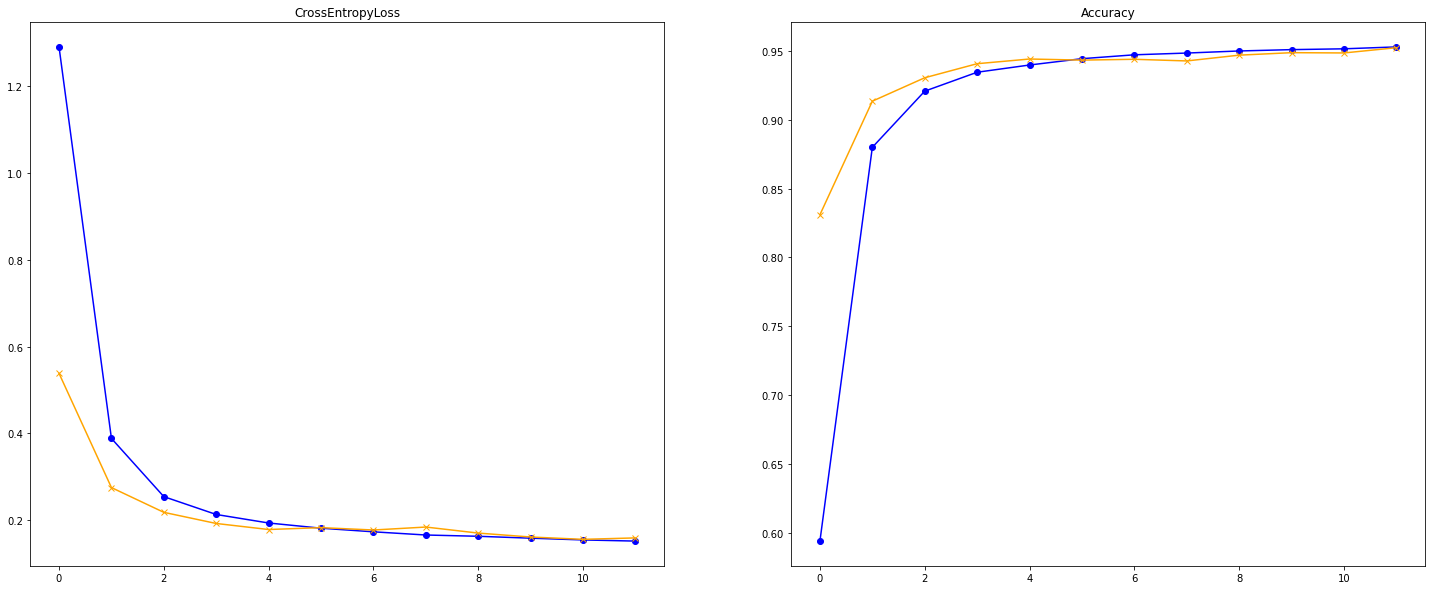

In [86]:

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
e = np.arange(NUM_EPOCHS)

ax1.plot(e, training_losses, color='blue', marker='o', label='train')
ax1.plot(e, validation_losses, color='orange', marker='x', label='validation')
ax1.set_title('CrossEntropyLoss')

ax2.plot(e, training_accuracies, color='blue', marker='o', label='train')
ax2.plot(e, validation_accuracies, color='orange', marker='x', label='validation')
ax2.set_title('Accuracy')

In [87]:
validation_losses[-1], validation_accuracies[-1]

(0.15933841396309437, 0.9521999999999993)

We were able to achieve 95% accuracy on our first try without even tuning hyperparemeters, what a result! We can try submitting this to the kaggle competition:

In [88]:
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
inputs = torch.unsqueeze(torch.reshape(torch.tensor(test_df[test_df.columns].values), (28000, 28, 28)), 1)
inputs = inputs / 255

input_batches = torch.split(inputs, BATCH_SIZE)

prediction_batches = []
for batch in input_batches:
    with torch.no_grad():
        prediction_batches.append(nn.forward(batch))


In [89]:
prediction_tensors = torch.cat(prediction_batches)
predictions = torch.argmax(prediction_tensors, 1)

In [90]:
submission_df = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': predictions.detach().numpy()})
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [91]:
submission_df.to_csv('submission.csv', index=False)

We scored 96% accuracy, a MASSIVE 6% improvement over our previous submissions with the old neural net. What a result! This shows how powerful these techniques can be, despite their simplicity.